In [226]:
import os
import glob
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional,GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from time import time
import itertools
from math import sqrt
import seaborn as sns

# Data import

In [227]:
path = r'/jet/home/mhrahman/Projects/HW5/'
data = pd.read_csv('DS-1_36W_vapor_fraction.txt',sep = '\t')
data = data.rename(columns={'Time (ms)':'Time','Vapor Fraction':'Vapor Fraction'})
v_data  = list(data['Vapor Fraction'])

In [124]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#v_data = scaler.fit_transform(data['Vapor Fraction'].values.reshape(-1,1)).flatten()

In [228]:
data

,Time,Vapor Fraction
0,0.333333,0.566644
1,0.666667,0.564461
2,1.000000,0.562855
3,1.333333,0.565662
4,1.666667,0.563902
...,...,...
4994,1665.000000,0.567091
4995,1665.333333,0.565522
4996,1665.666667,0.565640
4997,1666.000000,0.565539


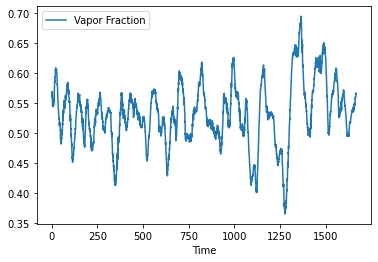

In [229]:
data.plot.line(x = 'Time', y = 'Vapor Fraction')
plt.savefig(r'/jet/home/mhrahman/Projects/HW5/Figures/Timeseries.jpg',dpi = 300)
plt.show()

# Input and output data generation

In [230]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Finding the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # Checking if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # Gather input and output parts of pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix : out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [251]:
steps_in = 50
steps_out = 50
X, Y = split_sequence(v_data,steps_in,steps_out)

In [252]:
X = np.reshape(X,(X.shape[0],X.shape[1],1))
X.shape

(4900, 50, 1)

# Train test split

In [253]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size= 0.2,shuffle = False)

# Model building

In [254]:
model_LSTM = Sequential([
    LSTM(50,input_shape = (x_train.shape[1],x_train.shape[2]),activation = 'relu'),
    Dropout(0.2),
    Dense(steps_out,activation = 'linear')
])

In [186]:
model_biLSTM = Sequential([
    Bidirectional(LSTM(50),input_shape = (x_train.shape[1],x_train.shape[2])),
    Dropout(0.2),
    Dense(steps_out)
])

In [187]:
model_GRU = Sequential([
    GRU(50, input_shape = (x_train.shape[1],x_train.shape[2])),
    Dropout(0.2),
    Dense(steps_out)
])

In [188]:
model_biGRU = Sequential([
    Bidirectional(GRU(50),input_shape = (x_train.shape[1],x_train.shape[2])),
    Dropout(0.2),
    Dense(steps_out)
])

In [255]:
model = model_LSTM
model.summary()
with open('modelsummary_LSTM_2.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
Total params: 12,950
Trainable params: 12,950
Non-trainable params: 0
_________________________________________________________________


# Call backs

In [256]:
class TimeCallback(Callback):
    def on_train_begin(self,logs={}):
        self.logs=[]
    def on_epoch_begin(self,epoch,logs={}):
        self.starttime = time()
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(time()-self.starttime)
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience = 5,min_delta = 1)
cb = TimeCallback()
checkpoints = ModelCheckpoint('weight.hdf5',monitor='loss',verbose=1,save_best_only= True,mode='min')

# Model compilation and fitting

In [257]:
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [258]:
epochs = 100
batch = 32
t1 = time()
history = model.fit(x_train,y_train,epochs=epochs,
                    batch_size = batch,validation_split= .2,verbose = 1,
                    callbacks = [cb,checkpoints,es],
                   shuffle = False)
t2 = time()

Train on 3136 samples, validate on 784 samples
Epoch 1/100
3104/3136 [============================>.] - ETA: 0s - loss: 0.0911
Epoch 00001: loss improved from inf to 0.09036, saving model to weight.hdf5
3136/3136 [==============================] - 9s 3ms/sample - loss: 0.0904 - val_loss: 0.0060
Epoch 2/100
3104/3136 [============================>.] - ETA: 0s - loss: 0.0115
Epoch 00002: loss improved from 0.09036 to 0.01145, saving model to weight.hdf5
3136/3136 [==============================] - 8s 3ms/sample - loss: 0.0115 - val_loss: 0.0028
Epoch 3/100
3104/3136 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 00003: loss improved from 0.01145 to 0.00847, saving model to weight.hdf5
3136/3136 [==============================] - 8s 3ms/sample - loss: 0.0085 - val_loss: 0.0026
Epoch 4/100
3104/3136 [============================>.] - ETA: 0s - loss: 0.0068
Epoch 00004: loss improved from 0.00847 to 0.00675, saving model to weight.hdf5
3136/3136 [===========================

# Model Evaluation

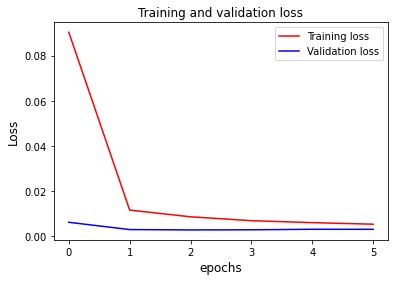

In [259]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title('Training and validation loss')
plt.xlabel('epochs',fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.legend(["Training loss","Validation loss"])
plt.savefig(r'/jet/home/mhrahman/Projects/HW5/Figures/Loss.jpg', dpi = 300)
plt.show()

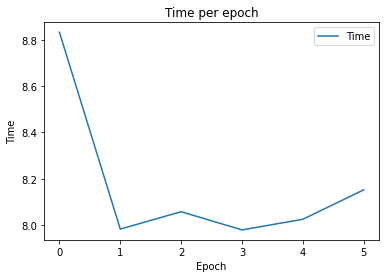

In [260]:
plt.plot(cb.logs)
plt.title('Time per epoch')
plt.xlabel('Epoch')
plt.ylabel('Time')
plt.legend(['Time'],loc = 'upper right')
#path = r'/jet/home/mhrahman/Projects/HW1/Figures/Classification_loss.jpg'
plt.savefig(r'/jet/home/mhrahman/Projects/HW5/Figures/Time.jpg', dpi = 300)
plt.show()

In [261]:
y_predicted = model.predict(x_test)
error = sqrt(mean_squared_error(y_true=y_test,y_pred=y_predicted))
print(error, t2-t1)

0.03456426386827481 49.12796473503113


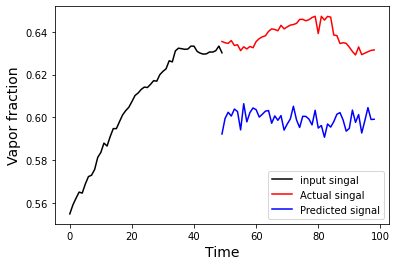

In [262]:
in_ = np.reshape(x_test,(x_test.shape[0],x_test.shape[1]))[0]
Actual = y_test[0]
Predicted = y_predicted[0]
plt.plot(range(0,steps_in),in_,color = 'black',label = 'input singal')
plt.plot(range(steps_in-1,steps_in+steps_out-1),Actual,color = 'red',label = 'Actual singal')
plt.plot(range(steps_in-1,steps_in+steps_out-1),Predicted,color = 'blue',label = 'Predicted signal')
plt.xlabel('Time',fontsize = 14)
plt.ylabel('Vapor fraction',fontsize = 14)
plt.legend()
plt.savefig(r'/jet/home/mhrahman/Projects/HW5/Figures/Signal.jpg',dpi = 300)
plt.show()

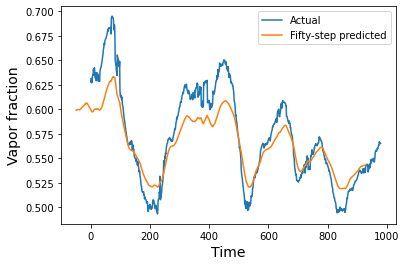

In [265]:
tr = []
pr = []
for i in range(len(y_test)):
    tr.append(y_test[i][steps_out-1])
    pr.append(y_predicted[i][steps_out-1])

plt.plot(tr,label = "Actual")
plt.plot(range(-50,len(pr)-50),pr,label = "Fifty-step predicted")
plt.legend()
plt.xlabel('Time',fontsize = 14)
plt.ylabel('Vapor fraction',fontsize = 14)
plt.savefig(r'/jet/home/mhrahman/Projects/HW5/Figures/Total_50.jpg',dpi = 300)
plt.show()

# Testing varying input and output length

In [86]:
def error_image(step_in, step_out, data,epochs, batch):
    X,Y = split_sequence(data, step_in, step_out)
    X = np.reshape(X,(X.shape[0],X.shape[1],1))
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size= 0.2,shuffle = False)
    model_LSTM_2 = Sequential([
    LSTM(50,input_shape = (x_train.shape[1],x_train.shape[2])),
    Dropout(0.2),
    Dense(step_out)])
    model = model_LSTM_2
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    model.fit(x_train,y_train,epochs=epochs,
                    batch_size = batch,validation_split= .2,verbose = 1,
                   shuffle = False,callbacks = [es])
    y_predicted = model.predict(x_test)
    error = sqrt(mean_squared_error(y_true=y_test,y_pred=y_predicted))
    return error

In [91]:
epochs = 15
batch = 32
periods = [25,50,75,100,125,150,175,200]
total_error = []
for i in periods:
    error = []
    for j in periods:
        print("Training for:", i,j)
        er = error_image(i,j,v_data,epochs, batch)
        error.append(er)
    total_error.append(error)

Training for: 25 25
Train on 3168 samples, validate on 792 samples
3168/3168 [==============================] - 5s 2ms/sample - loss: 0.1068 - val_loss: 0.0038
Training for: 25 50
Train on 3152 samples, validate on 788 samples
3152/3152 [==============================] - 7s 2ms/sample - loss: 0.1040 - val_loss: 0.0039
Training for: 25 75
Train on 3136 samples, validate on 784 samples
3136/3136 [==============================] - 7s 2ms/sample - loss: 0.0961 - val_loss: 0.0116
Training for: 25 100
Train on 3120 samples, validate on 780 samples
3120/3120 [==============================] - 5s 2ms/sample - loss: 0.0937 - val_loss: 0.0094
Training for: 25 125
Train on 3104 samples, validate on 776 samples
3104/3104 [==============================] - 6s 2ms/sample - loss: 0.0944 - val_loss: 0.0110
Training for: 25 150
Train on 3088 samples, validate on 772 samples
3088/3088 [==============================] - 6s 2ms/sample - loss: 0.0815 - val_loss: 0.0110
Training for: 25 175
Train on 3072 sa

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [20]:
t = np.array(total_error)
np.save("total.npy",t)

NameError: name 'total_error' is not defined

# Ploting the RMSE as heatmap

In [25]:
periods = [25,50,75,100,125,150,175,200]
df = pd.DataFrame(np.load('total.npy'),columns = periods,index = periods)
df

,25,50,75,100,125,150,175,200
25,0.023868,0.033878,0.040942,0.045768,0.047754,0.050334,0.052212,0.053568
50,0.024400,0.033632,0.040296,0.047425,0.049708,0.051926,0.054857,0.054075
75,0.024789,0.034504,0.040360,0.044982,0.049900,0.050633,0.054703,0.054784
100,0.024641,0.033854,0.041248,0.045054,0.049316,0.049669,0.052954,0.053442
125,0.025744,0.033843,0.041957,0.044949,0.048502,0.051703,0.053974,0.056907
150,0.030218,0.033840,0.043066,0.045135,0.049259,0.050350,0.054937,0.055030
175,0.028828,0.035109,0.041617,0.049458,0.049301,0.054526,0.053646,0.055493
200,0.030701,0.034253,0.045742,0.046048,0.050306,0.052639,0.054813,0.058196


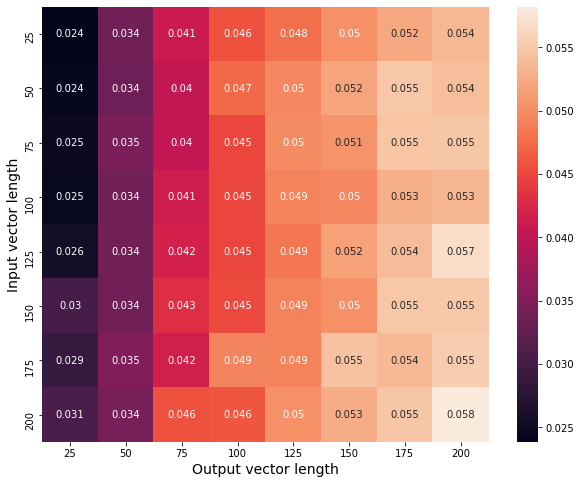

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(df,annot=True)
plt.xlabel("Output vector length", fontsize = 14)
plt.ylabel("Input vector length", fontsize = 14)
plt.savefig(r'/jet/home/mhrahman/Projects/HW5/Figures/Heatmap.jpg',dpi = 300)
plt.show()